<a href="https://colab.research.google.com/github/maqnitude/games-recommender/blob/master/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports & Settings

from __future__ import print_function

import collections

import numpy as np
import pandas as pd
from IPython import display
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Pandas DataFrame settings
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.6f}'.format

def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Project settings
import os
from google.colab import drive
drive.mount("/content/drive/")

BASE_DIR = "/content/drive/MyDrive/CS114/"
DATA_DIR = os.path.join(BASE_DIR, "datasets/steam")

USER_RATINGS = True

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# @title Read data

def min_max_normalize(df, cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Read the csv files
games = pd.read_csv(os.path.join(DATA_DIR, 'games.csv'),
                    encoding='utf-8')
# Fix typo :)
games = games.rename(columns={'total_reivews': 'total_reviews'})

recs = pd.read_csv(os.path.join(DATA_DIR, 'reviews.csv'),
                        encoding='utf-8')

In [ ]:
games

,app_id,name,required_age,is_free,developers,publishers,platforms_windows,platforms_mac,platforms_linux,metacritic,categories,genres,recommendations,coming_soon,release_date,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,10,Counter-Strike,0,False,Valve,Valve,True,True,True,88.0,Multi-player|PvP|Online PvP|Shared/Split Scree...,Action,145755.0,False,"1 Nov, 2000",9,Overwhelmingly Positive,28802,997,29799
1,20,Team Fortress Classic,0,False,Valve,Valve,True,True,True,NaN,Multi-player|PvP|Online PvP|Shared/Split Scree...,Action,5857.0,False,"1 Apr, 1999",8,Very Positive,3098,509,3607
2,40,Deathmatch Classic,0,False,Valve,Valve,True,True,True,NaN,Multi-player|PvP|Online PvP|Shared/Split Scree...,Action,2044.0,False,"1 Jun, 2001",8,Very Positive,887,196,1083
3,50,Half-Life: Opposing Force,0,False,Gearbox Software,Valve,True,True,True,NaN,Single-player|Multi-player|Valve Anti-Cheat en...,Action,17690.0,False,"1 Nov, 1999",9,Overwhelmingly Positive,9309,457,9766
4,70,Half-Life,0,False,Valve,Valve,True,True,True,96.0,Single-player|Multi-player|PvP|Online PvP|Full...,Action,87707.0,False,"8 Nov, 1998",9,Overwhelmingly Positive,42651,1575,44226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,2685210,Where Jellyfish 水母在哪里,0,True,冷笑黑妖,冷笑黑妖,True,False,False,NaN,Single-player|Steam Achievements,Casual|Indie,NaN,False,"21 Dec, 2023",0,No user reviews,0,0,0
4582,2693460,Christmas Nightmare,0,False,JustTomcuk,JustTomcuk,True,False,False,NaN,Single-player|Steam Achievements,Adventure|Indie|Simulation,145.0,False,"3 Dec, 2023",8,Very Positive,50,3,53
4583,2695910,双生幻想,0,True,双生幻想,双生幻想,True,False,False,NaN,Multi-player|MMO|PvP|Online PvP|Co-op|Online C...,Action|Indie|RPG,NaN,False,"19 Dec, 2023",0,No user reviews,0,0,0
4584,2695970,少年江山,0,True,少年江山,少年江山,True,False,False,NaN,Multi-player|MMO|PvP|Online PvP|In-App Purchases,Action|Indie|RPG,NaN,False,"30 Nov, 2023",0,No user reviews,0,0,0


In [ ]:
recs

,recommendation_id,steam_id,app_id,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,100020115,76561199179315712,1481400,0,2,331,0,67,1632731902,1632704336,1632704336,True,0,0,0.000000,0,True,False,False
1,100023829,76561198389277138,1481400,37,6,128,0,30,1633158010,1632712163,1632712163,True,1,0,0.000000,0,True,False,False
2,100024167,76561198118826053,1481400,0,6,60,0,30,1632712996,1632712925,1632712925,True,0,0,0.000000,0,True,False,False
3,100032295,76561199164581905,1481400,205,7,59,0,31,1632733762,1632733686,1632733686,True,0,0,0.000000,0,True,False,False
4,100038950,76561198167364891,1481400,0,4,35,0,35,1632747691,1632747876,1632747876,True,12,0,0.659190,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261179,155959112,76561199070781148,17410,0,11,490,490,490,1705232940,1705232983,1705232983,True,1,0,0.523810,0,True,False,False
261180,154731046,76561198323891504,227300,0,6,1988,0,1988,1703808758,1703871445,1703871445,True,1,1,0.523810,0,True,False,False
261181,155913990,76561198022667949,261550,883,182,1426,1426,362,1705283060,1705177426,1705177426,False,1,0,0.508197,0,True,False,False
261182,155415130,76561199218287943,261570,56,12,1343,375,1343,1704568516,1704569625,1704569625,True,1,0,0.523810,0,True,False,False


# Data Preprocessing

In [ ]:
# @title Merge games into reviews
merged_recs = pd.merge(recs, games, on='app_id', how='left')

In [ ]:
merged_recs

,recommendation_id,steam_id,app_id,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,...,categories,genres,recommendations,coming_soon,release_date,review_score,review_score_desc,total_positive,total_negative,total_reviews
0,100020115,76561199179315712,1481400,0,2,331,0,67,1632731902,1632704336,...,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|Free to Play,NaN,False,"24 Sep, 2021",8,Very Positive,55,0,55
1,100023829,76561198389277138,1481400,37,6,128,0,30,1633158010,1632712163,...,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|Free to Play,NaN,False,"24 Sep, 2021",8,Very Positive,55,0,55
2,100024167,76561198118826053,1481400,0,6,60,0,30,1632712996,1632712925,...,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|Free to Play,NaN,False,"24 Sep, 2021",8,Very Positive,55,0,55
3,100032295,76561199164581905,1481400,205,7,59,0,31,1632733762,1632733686,...,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|Free to Play,NaN,False,"24 Sep, 2021",8,Very Positive,55,0,55
4,100038950,76561198167364891,1481400,0,4,35,0,35,1632747691,1632747876,...,Single-player|Steam Achievements|Full controll...,Adventure|Casual|Indie|Free to Play,NaN,False,"24 Sep, 2021",8,Very Positive,55,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261179,155959112,76561199070781148,17410,0,11,490,490,490,1705232940,1705232983,...,Single-player|Full controller support|Steam Tr...,Action|Adventure,27535.0,False,"14 Jan, 2009",8,Very Positive,11200,1741,12941
261180,154731046,76561198323891504,227300,0,6,1988,0,1988,1703808758,1703871445,...,Single-player|Multi-player|Co-op|Online Co-op|...,Indie|Simulation,565607.0,False,"12 Oct, 2012",9,Overwhelmingly Positive,101413,2361,103774
261181,155913990,76561198022667949,261550,883,182,1426,1426,362,1705283060,1705177426,...,Single-player|Multi-player|PvP|Online PvP|Stea...,Action|Indie|RPG|Simulation|Strategy,183688.0,False,"25 Oct, 2022",8,Very Positive,72468,10073,82541
261182,155415130,76561199218287943,261570,56,12,1343,375,1343,1704568516,1704569625,...,Single-player|Steam Achievements|Full controll...,Action,44896.0,False,"10 Mar, 2015",9,Overwhelmingly Positive,12421,562,12983


In [ ]:
# @title One-hot encodings
# merged_recs['developers'] = merged_recs['developers'].str.split('|')
# merged_recs['publishers'] = merged_recs['publishers'].str.split('|')
merged_recs['categories'] = merged_recs['categories'].str.split('|')
merged_recs['genres'] = merged_recs['genres'].str.split('|')

# encoded_developers = merged_recs['developers'].str.join('|').str.get_dummies()
# encoded_publishers = merged_recs['publishers'].str.join('|').str.get_dummies()
encoded_categories = merged_recs['categories'].str.join('|').str.get_dummies()
encoded_genres = merged_recs['genres'].str.join('|').str.get_dummies()

encoded_merged_recs = pd.concat([merged_recs, encoded_categories, encoded_genres], axis=1)

In [ ]:
# @title Min-max nomalization
cols_to_normalize = [
    'num_games_owned',
    'num_reviews',
    'playtime_forever',
    'playtime_last_two_weeks',
    'playtime_at_review',
    'votes_up',
    'votes_funny',
    'comment_count',
    'review_score',
    'total_positive',
    'total_negative',
    'total_reviews'
]

scaler = MinMaxScaler()

encoded_merged_recs[cols_to_normalize] = scaler.fit_transform(encoded_merged_recs[cols_to_normalize])

In [ ]:
encoded_merged_recs

,recommendation_id,steam_id,app_id,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,...,Massively Multiplayer,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Violent,Web Publishing
0,100020115,76561199179315712,1481400,0.000000,0.000093,0.000091,0.000000,0.000019,1632731902,1632704336,...,0,0,0,0,0,0,0,0,0,0
1,100023829,76561198389277138,1481400,0.001267,0.000464,0.000035,0.000000,0.000009,1633158010,1632712163,...,0,0,0,0,0,0,0,0,0,0
2,100024167,76561198118826053,1481400,0.000000,0.000464,0.000017,0.000000,0.000009,1632712996,1632712925,...,0,0,0,0,0,0,0,0,0,0
3,100032295,76561199164581905,1481400,0.007019,0.000557,0.000016,0.000000,0.000009,1632733762,1632733686,...,0,0,0,0,0,0,0,0,0,0
4,100038950,76561198167364891,1481400,0.000000,0.000279,0.000010,0.000000,0.000010,1632747691,1632747876,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261179,155959112,76561199070781148,17410,0.000000,0.000929,0.000135,0.022199,0.000139,1705232940,1705232983,...,0,0,0,0,0,0,0,0,0,0
261180,154731046,76561198323891504,227300,0.000000,0.000464,0.000548,0.000000,0.000564,1703808758,1703871445,...,0,0,0,0,1,0,0,0,0,0
261181,155913990,76561198022667949,261550,0.030235,0.016814,0.000393,0.064604,0.000103,1705283060,1705177426,...,0,0,1,0,1,0,1,0,0,0
261182,155415130,76561199218287943,261570,0.001917,0.001022,0.000370,0.016989,0.000381,1704568516,1704569625,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# @title Pseudo ratings

weights = {
    'weighted_vote_score': 0.5,
    'playtime_forever': 0.2,
    'voted_up': 0.1,
    'num_reviews': 0.05,
    'total_reviews': 0.05,
    'total_positive': 0.05,
    'total_negative': 0.05,
}

interaction_weights = {
    'voted_up_total_positive_negative_reviews': 0.25,
    'playtime_voted_up': 0.25,
    'playtime_category': 0.25,
    'playtime_genre': 0.25,
}

weights = {key: 0.5 * value for key, value in weights.items()}
interaction_weights = {key: 0.5 * value for key, value in interaction_weights.items()}

encoded_merged_recs['pseudo_ratings'] = sum(encoded_merged_recs[col] * w for col, w in weights.items())

encoded_merged_recs['pseudo_ratings'] += sum(
    encoded_merged_recs['voted_up'] *
    encoded_merged_recs['total_positive'] *
    encoded_merged_recs['total_negative'] *
    encoded_merged_recs['total_reviews'] *
    interaction_weights['voted_up_total_positive_negative_reviews']
)

encoded_merged_recs['pseudo_ratings'] += sum(
    encoded_merged_recs['playtime_forever'] * encoded_merged_recs['voted_up'] *
    interaction_weights['playtime_voted_up']
)

encoded_merged_recs['pseudo_ratings'] += sum(
    encoded_merged_recs['playtime_forever'] * encoded_merged_recs[category] *
    (interaction_weights['playtime_category'] / len(encoded_categories.columns))
    for category in encoded_categories.columns
)

encoded_merged_recs['pseudo_ratings'] += sum(
    encoded_merged_recs['playtime_forever'] * encoded_merged_recs[genre] *
    (interaction_weights['playtime_genre'] / len(encoded_genres.columns))
    for genre in encoded_genres.columns
)

# min-max normalization
min_rating = encoded_merged_recs['pseudo_ratings'].min()
max_rating = encoded_merged_recs['pseudo_ratings'].max()

# encoded_merged_recs['pseudo_ratings'] = 1 + (encoded_merged_recs['pseudo_ratings'] - min_rating) * 4 / (max_rating - min_rating)
encoded_merged_recs['pseudo_ratings'] = (encoded_merged_recs['pseudo_ratings'] - min_rating) / (max_rating - min_rating)

In [ ]:
encoded_merged_recs

,recommendation_id,steam_id,app_id,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,...,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Violent,Web Publishing,pseudo_ratings
0,100020115,76561199179315712,1481400,0.000000,0.000093,0.000091,0.000000,0.000019,1632731902,1632704336,...,0,0,0,0,0,0,0,0,0,0.102667
1,100023829,76561198389277138,1481400,0.001267,0.000464,0.000035,0.000000,0.000009,1633158010,1632712163,...,0,0,0,0,0,0,0,0,0,0.102670
2,100024167,76561198118826053,1481400,0.000000,0.000464,0.000017,0.000000,0.000009,1632712996,1632712925,...,0,0,0,0,0,0,0,0,0,0.102664
3,100032295,76561199164581905,1481400,0.007019,0.000557,0.000016,0.000000,0.000009,1632733762,1632733686,...,0,0,0,0,0,0,0,0,0,0.102669
4,100038950,76561198167364891,1481400,0.000000,0.000279,0.000010,0.000000,0.000010,1632747691,1632747876,...,0,0,0,0,0,0,0,0,0,0.440925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261179,155959112,76561199070781148,17410,0.000000,0.000929,0.000135,0.022199,0.000139,1705232940,1705232983,...,0,0,0,0,0,0,0,0,0,0.373193
261180,154731046,76561198323891504,227300,0.000000,0.000464,0.000548,0.000000,0.000564,1703808758,1703871445,...,0,0,0,1,0,0,0,0,0,0.381720
261181,155913990,76561198022667949,261550,0.030235,0.016814,0.000393,0.064604,0.000103,1705283060,1705177426,...,0,1,0,1,0,1,0,0,0,0.272196
261182,155415130,76561199218287943,261570,0.001917,0.001022,0.000370,0.016989,0.000381,1704568516,1704569625,...,0,0,0,0,0,0,0,0,0,0.372922


In [ ]:
# @title Mapping steam_id and app_id
recs_app_ids = encoded_merged_recs['app_id'].unique()
games = games[games['app_id'].isin(recs_app_ids)]
games = games.reset_index(drop=True)

steam_id_mapping = {id: i for i, id in enumerate(encoded_merged_recs['steam_id'].unique())}
app_id_mapping = {id: i for i, id in enumerate(games['app_id'].unique())}

merged_recs.loc[:, 'steam_id'] = merged_recs['steam_id'].apply(lambda x: steam_id_mapping[x])
merged_recs.loc[:, 'app_id'] = merged_recs['app_id'].apply(lambda x: app_id_mapping[x])
encoded_merged_recs.loc[:, 'steam_id'] = encoded_merged_recs['steam_id'].apply(lambda x: steam_id_mapping[x])
encoded_merged_recs.loc[:, 'app_id'] = encoded_merged_recs['app_id'].apply(lambda x: app_id_mapping[x])
games.loc[:, 'app_id'] = games['app_id'].apply(lambda x: app_id_mapping[x])

num_users = encoded_merged_recs['steam_id'].nunique()
num_games = games['app_id'].nunique()

In [ ]:
encoded_merged_recs

,recommendation_id,steam_id,app_id,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,timestamp_created,...,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Violent,Web Publishing,pseudo_ratings
0,100020115,0,3263,0.000000,0.000093,0.000091,0.000000,0.000019,1632731902,1632704336,...,0,0,0,0,0,0,0,0,0,0.102667
1,100023829,1,3263,0.001267,0.000464,0.000035,0.000000,0.000009,1633158010,1632712163,...,0,0,0,0,0,0,0,0,0,0.102670
2,100024167,2,3263,0.000000,0.000464,0.000017,0.000000,0.000009,1632712996,1632712925,...,0,0,0,0,0,0,0,0,0,0.102664
3,100032295,3,3263,0.007019,0.000557,0.000016,0.000000,0.000009,1632733762,1632733686,...,0,0,0,0,0,0,0,0,0,0.102669
4,100038950,4,3263,0.000000,0.000279,0.000010,0.000000,0.000010,1632747691,1632747876,...,0,0,0,0,0,0,0,0,0,0.440925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261179,155959112,229896,145,0.000000,0.000929,0.000135,0.022199,0.000139,1705232940,1705232983,...,0,0,0,0,0,0,0,0,0,0.373193
261180,154731046,229897,441,0.000000,0.000464,0.000548,0.000000,0.000564,1703808758,1703871445,...,0,0,0,1,0,0,0,0,0,0.381720
261181,155913990,48468,595,0.030235,0.016814,0.000393,0.064604,0.000103,1705283060,1705177426,...,0,1,0,1,0,1,0,0,0,0.272196
261182,155415130,229898,596,0.001917,0.001022,0.000370,0.016989,0.000381,1704568516,1704569625,...,0,0,0,0,0,0,0,0,0,0.372922


### Inspecting pseudo ratings

In [ ]:
games_ratings = games.merge(
    encoded_merged_recs
    .groupby('app_id', as_index=False)
    .agg({'pseudo_ratings': ['count', 'mean']})
    .flatten_cols(),
    on='app_id'
)

In [ ]:
(games_ratings[['name', 'pseudo_ratings count', 'pseudo_ratings mean']]
 .sort_values('pseudo_ratings count', ascending=False)
 .head(10))

,name,pseudo_ratings count,pseudo_ratings mean
2480,Baldur's Gate 3,4018,0.405340
2592,Ready or Not,3599,0.338469
19,Counter-Strike 2,3337,0.500293
2680,Red Dead Redemption 2,2481,0.383788
563,Rust,2081,0.418318
638,Grand Theft Auto V,1959,0.425923
831,Geometry Dash,1822,0.386381
2491,Cyberpunk 2077,1594,0.412730
968,Tom Clancy's Rainbow Six® Siege,1567,0.387131
2825,ELDEN RING,1430,0.410192


In [ ]:
(games_ratings[['name', 'pseudo_ratings count', 'pseudo_ratings mean']]
 .mask('pseudo_ratings count', lambda x: x > 1)
 .sort_values('pseudo_ratings mean', ascending=False)
 .head(10))

,name,pseudo_ratings count,pseudo_ratings mean
323,Arma 3,100,0.607757
671,This War of Mine,109,0.589644
159,The Witcher: Enhanced Edition Director's Cut,100,0.572576
160,The Witcher 2: Assassins of Kings Enhanced Edi...,101,0.569688
19,Counter-Strike 2,3337,0.500293
674,Star Ruler 2,22,0.496727
40,X3: Terran Conflict,25,0.489733
216,Red Orchestra 2: Heroes of Stalingrad with Ris...,153,0.483206
1083,NOBUNAGA'S AMBITION: Sphere of Influence,21,0.481665
1118,Nex Machina,21,0.464855


# Helper functions

In [ ]:
def build_rating_sparse_tensor(recs_df):
    indices = recs_df[['steam_id', 'app_id']].values
    values = recs_df['pseudo_ratings'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[num_users, num_games]
    )

In [ ]:
def sparse_MSE(sparse_ratings, user_embeddings, game_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(game_embeddings, sparse_ratings.indices[:, 1]),
        axis=1
    )
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

In [ ]:
# @title CFModel helper class
class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
            embedding_vars: A dictionary of tf.Variables.
            loss: A float Tensor. The loss to optimize.
            metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
            iterations: number of iterations to run.
            learning_rate: optimizer learning rate.
            plot_results: whether to plot the results at the end of training.
            optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
            The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer()
            )
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end=''
                    )
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
        df: a dataframe.
        holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
        train: dataframe for training
        test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    """
    Args:
        ratings: a DataFrame of the ratings
        embedding_dim: the dimension of the embedding vectors.
        init_stddev: float, the standard deviation of the random initial embeddings.
    Returns:
        model: a CFModel.
    """
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random.normal(
        [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
        [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_MSE(A_train, U, V)
    test_loss = sparse_MSE(A_test, U, V)
    metrics = {
        'train_error': train_loss,
        'test_error': test_loss
    }
    embeddings = {
        "steam_id": U,
        "app_id": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
        query_embedding: a vector of shape [k], representing the query embedding.
        item_embeddings: a matrix of shape [N, k], such that row i is the embedding
            of item i.
        measure: a string specifying the similarity measure to be used. Can be
            either DOT or COSINE.
    Returns:
        scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [ ]:
def user_recommendations(user_embeddings, game_embeddings, id, measure=DOT, exclude_rated=False, k=6):
    if USER_RATINGS:
        print(f"This user (id: {id}) reviewed the following games:")
        display.display(merged_recs[merged_recs['steam_id'] == id][['steam_id', 'app_id', 'name', 'voted_up', 'playtime_forever', 'categories', 'genres']])
        scores = compute_scores(
            user_embeddings[id],
            game_embeddings,
            measure
        )
        score_key = measure + ' score'
        df = pd.DataFrame({
            score_key: list(scores),
            'app_id': games['app_id'],
            'name': games['name'],
            'categories': games['categories'],
            'genres': games['genres']
        })
        if exclude_rated:
            rated_games = recs[recs.steam_id == id]['app_id'].values
            df = df[df.app_id.apply(lambda app_id: app_id not in rated_games)]
        print("Recommendations:")
        display.display(df.sort_values([score_key], ascending=False).head(k))

def game_neighbors(game_embeddings, name_substring, measure=DOT, k=6):
    ids = games[games['name'].str.contains(name_substring)].index.values
    names = games.iloc[ids]['name'].values
    if len(names) == 0:
        raise ValueError(f"Found no game with name: {name_substring}")
    print(f"Nearest neighbors of: {names[0]}")
    if len(names) > 1:
        print("[Found more than 1 matching game. Other candidates: {}]".format(
            ", ".join(names[1:])
        ))
    app_id = ids[0]
    scores = compute_scores(
        game_embeddings[app_id],
        game_embeddings,
        measure
    )
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'name': games['name'],
        'categories': games['categories'],
        'genres': games['genres']
    })
    display.display(df.sort_values([score_key], ascending=False).head(k))

# Experiment

## Matrix factorization (no regularization)

 iteration 2000: train_error=0.066450, test_error=1.455429

[{'train_error': 0.06645002, 'test_error': 1.4554286}]

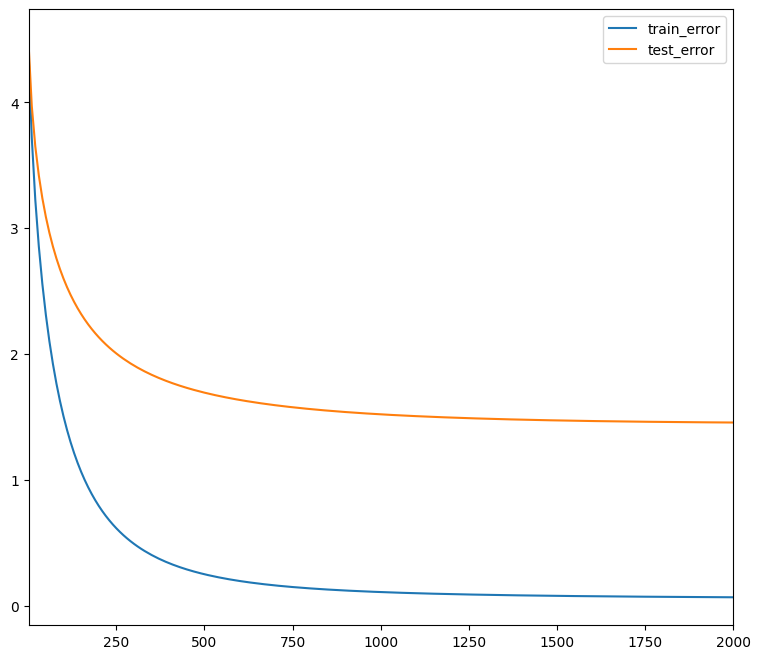

In [ ]:
# @title Build and train the matrix factorization model
model = build_model(encoded_merged_recs, embedding_dim=70, init_stddev=0.5)
model.train(num_iterations=2000, learning_rate=10.0)

In [ ]:
# @title Apply dimensionality reduction (PCA) to user_embeddings and game_embeddings

from sklearn.decomposition import PCA

user_embeddings = model.embeddings['steam_id']
game_embeddings = model.embeddings['app_id']

pca = PCA(n_components=35)
user_embeddings_pca = pca.fit_transform(user_embeddings)
game_embeddings_pca = pca.fit_transform(game_embeddings)

In [ ]:
# @title Nearest neighbors of a game
game = "Counter-Strike 2"
game_neighbors(model.embeddings['app_id'], game, DOT)
game_neighbors(model.embeddings['app_id'], game, COSINE)

Nearest neighbors of: Counter-Strike 2


,dot score,name,categories,genres
867,0.322354,Dark Deception,Single-player|Steam Achievements|Captions avai...,Action|Adventure|Indie|Free to Play
2988,0.308954,Karting,Single-player|Multi-player|PvP|Online PvP|Stea...,Casual|Indie|Racing|Simulation
3913,0.290993,One-armed cook,Single-player|Multi-player|Co-op|Online Co-op,Casual|Simulation|Free to Play
3049,0.284913,STRANGER OF PARADISE FINAL FANTASY ORIGIN,Single-player|Multi-player|Co-op|Online Co-op|...,Action|Adventure|RPG
1486,0.257050,Wonder Boy: The Dragon's Trap,Single-player|Steam Achievements|Steam Trading...,Action|Adventure|Indie
988,0.251438,Mind Snares: Alice's Journey,Single-player|Steam Achievements|Steam Trading...,Adventure|Casual


Nearest neighbors of: Counter-Strike 2


,cosine score,name,categories,genres
19,1.000000,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
2988,0.439010,Karting,Single-player|Multi-player|PvP|Online PvP|Stea...,Casual|Indie|Racing|Simulation
867,0.422377,Dark Deception,Single-player|Steam Achievements|Captions avai...,Action|Adventure|Indie|Free to Play
3913,0.419601,One-armed cook,Single-player|Multi-player|Co-op|Online Co-op,Casual|Simulation|Free to Play
3960,0.417499,Resident Evil 4,Single-player|Steam Achievements|Full controll...,Action|Adventure
3049,0.411313,STRANGER OF PARADISE FINAL FANTASY ORIGIN,Single-player|Multi-player|Co-op|Online Co-op|...,Action|Adventure|RPG


In [ ]:
# @title Nearest neighbors of a game (with PCA applied)
game_neighbors(game_embeddings_pca, game, DOT)
game_neighbors(game_embeddings_pca, game, COSINE)

Nearest neighbors of: Counter-Strike 2


,dot score,name,categories,genres
3049,0.233743,STRANGER OF PARADISE FINAL FANTASY ORIGIN,Single-player|Multi-player|Co-op|Online Co-op|...,Action|Adventure|RPG
2988,0.216146,Karting,Single-player|Multi-player|PvP|Online PvP|Stea...,Casual|Indie|Racing|Simulation
867,0.204197,Dark Deception,Single-player|Steam Achievements|Captions avai...,Action|Adventure|Indie|Free to Play
2460,0.200468,Main Assembly,Single-player|Multi-player|PvP|Online PvP|Co-o...,Simulation
2942,0.191180,Olija,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie
293,0.189319,Worms Crazy Golf,Single-player|Steam Achievements|Partial Contr...,Sports|Strategy


Nearest neighbors of: Counter-Strike 2


,cosine score,name,categories,genres
19,1.000000,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
3049,0.568153,STRANGER OF PARADISE FINAL FANTASY ORIGIN,Single-player|Multi-player|Co-op|Online Co-op|...,Action|Adventure|RPG
2988,0.567118,Karting,Single-player|Multi-player|PvP|Online PvP|Stea...,Casual|Indie|Racing|Simulation
867,0.510980,Dark Deception,Single-player|Steam Achievements|Captions avai...,Action|Adventure|Indie|Free to Play
1455,0.498681,Atelier Firis: The Alchemist and the Mysteriou...,Single-player|Steam Achievements|Partial Contr...,RPG
2460,0.488450,Main Assembly,Single-player|Multi-player|PvP|Online PvP|Co-o...,Simulation


In [ ]:
# @title User recommendations
id = 123123
user_recommendations(model.embeddings['steam_id'], model.embeddings['app_id'], id, DOT)
user_recommendations(model.embeddings['steam_id'], model.embeddings['app_id'], id, COSINE)

This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,dot score,app_id,name,categories,genres
1931,8.488958,1931,Maelstrom,Single-player|Multi-player|PvP|Online PvP|Co-o...,Action|Adventure|Free to Play|Indie|Massively ...
1128,6.572282,1128,Eventide: Slavic Fable,Single-player|Steam Achievements|Steam Trading...,Adventure|Casual
1735,6.382557,1735,Halcyon 6: Starbase Commander (LIGHTSPEED EDIT...,Single-player|Steam Achievements|Steam Trading...,Indie|RPG|Simulation|Strategy
2898,6.213607,2898,Mad Streets,Single-player|Multi-player|PvP|Online PvP|Shar...,Action|Casual|Indie
887,6.156373,887,Echoes+,Single-player|Full controller support,Action|Free to Play|Indie
1421,5.872676,1421,Nightshade／百花百狼,Single-player|Steam Achievements|Steam Trading...,Adventure


This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,cosine score,app_id,name,categories,genres
1931,0.448421,1931,Maelstrom,Single-player|Multi-player|PvP|Online PvP|Co-o...,Action|Adventure|Free to Play|Indie|Massively ...
3781,0.417723,3781,Hooked on You: A Dead by Daylight Dating Sim™,Single-player|Steam Achievements|Partial Contr...,Casual
4202,0.386203,4202,Parking Tycoon: Business Simulator,Single-player|Full controller support,Indie|Simulation|Strategy
333,0.348777,333,Batman: Arkham City - Game of the Year Edition,Single-player|Steam Achievements|Steam Trading...,Action|Adventure
1128,0.347922,1128,Eventide: Slavic Fable,Single-player|Steam Achievements|Steam Trading...,Adventure|Casual
47,0.340398,47,Insaniquarium Deluxe,Single-player,Casual


In [ ]:
# @title User recommendations (with PCA applied)
user_recommendations(user_embeddings_pca, game_embeddings_pca, id, DOT)
user_recommendations(user_embeddings_pca, game_embeddings_pca, id, COSINE)

This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,dot score,app_id,name,categories,genres
3688,5.582084,3688,Noble Fates,Single-player|Steam Workshop|Steam Cloud,Action|Indie|RPG|Simulation|Strategy|Early Access
2948,5.317316,2948,Cross Princess,Single-player|Steam Achievements|Steam Cloud,Adventure|Casual|Indie
2645,5.266334,2645,Midnight Protocol,Single-player|Steam Achievements|Steam Trading...,Action|Adventure|Indie|RPG|Strategy
966,5.048365,966,Amnesia™: Memories,Single-player|Steam Achievements|Steam Trading...,Adventure
3808,4.673798,3808,Dummynation,Single-player|Multi-player|PvP|Online PvP|Cros...,Indie|Simulation|Strategy
194,4.392031,194,Zombie Bowl-o-Rama,Single-player|Multi-player|Steam Achievements|...,Casual|Sports


This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,cosine score,app_id,name,categories,genres
2645,0.582722,2645,Midnight Protocol,Single-player|Steam Achievements|Steam Trading...,Action|Adventure|Indie|RPG|Strategy
3688,0.570109,3688,Noble Fates,Single-player|Steam Workshop|Steam Cloud,Action|Indie|RPG|Simulation|Strategy|Early Access
649,0.491347,649,Darkwood,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|RPG
194,0.488863,194,Zombie Bowl-o-Rama,Single-player|Multi-player|Steam Achievements|...,Casual|Sports
1147,0.474100,1147,Metro Exodus,Single-player|Steam Achievements|Full controll...,Action
2948,0.472385,2948,Cross Princess,Single-player|Steam Achievements|Steam Cloud,Adventure|Casual|Indie


## Matrix factorization with regularization

In [ ]:
# @title Function to calculate gravity loss
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

In [ ]:
# @title Function to build the regularized model
def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_MSE(A_train, U, V)
  error_test = sparse_MSE(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"steam_id": U, "app_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=0.105066, test_error_observed=0.161097, observed_loss=0.105066, regularization_loss=8.351556, gravity_loss=0.004625

[{'train_error_observed': 0.10506567, 'test_error_observed': 0.16109669},
 {'observed_loss': 0.10506567,
  'regularization_loss': 8.351556,
  'gravity_loss': 0.00462495}]

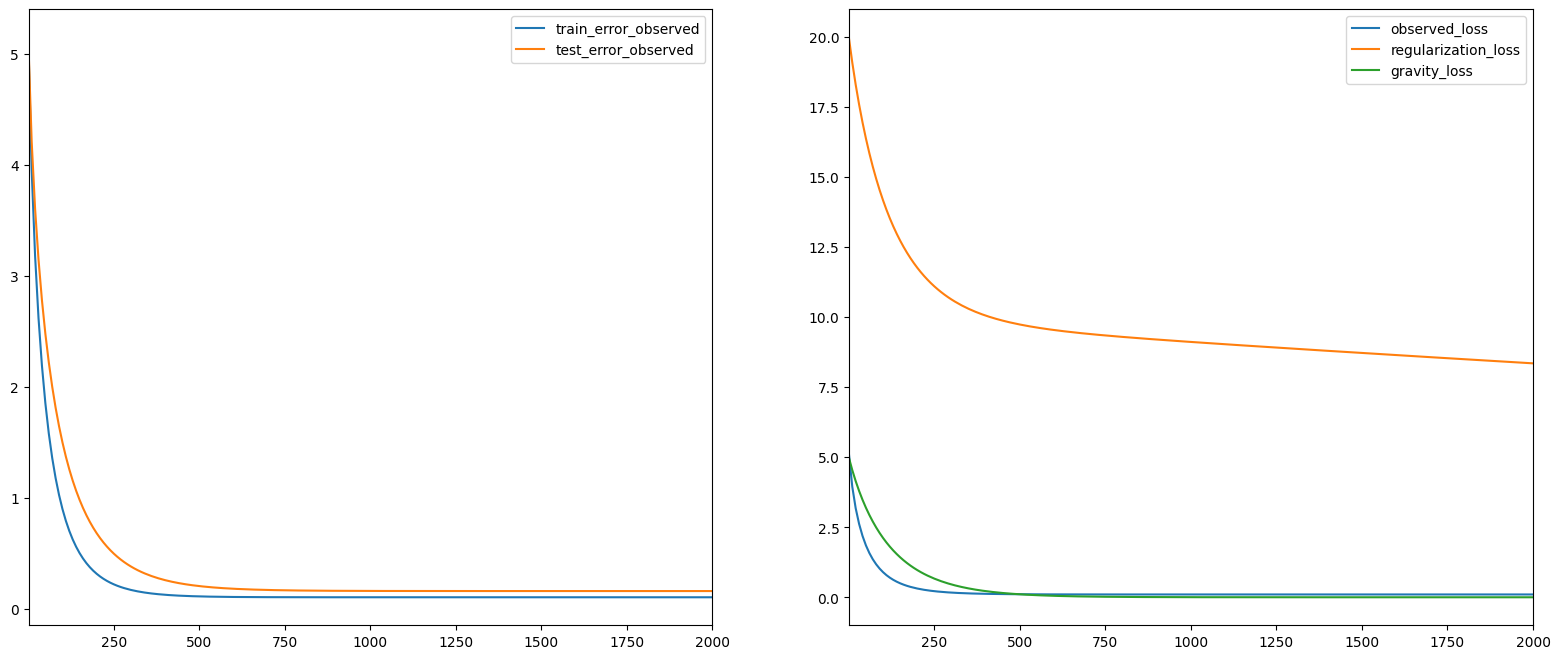

In [ ]:
# @title Build and train the regularized model
reg_model = build_regularized_model(
    encoded_merged_recs, regularization_coeff=0.5, gravity_coeff=1.0, embedding_dim=80,
    init_stddev=0.5
)
reg_model.train(num_iterations=2000, learning_rate=10.)

In [ ]:
# @title Apply PCA to user_embeddings and game_embeddings

reg_user_embeddings = reg_model.embeddings['steam_id']
reg_game_embeddings = reg_model.embeddings['app_id']

reg_pca = PCA(n_components=40)
reg_user_embeddings_pca = reg_pca.fit_transform(reg_user_embeddings)
reg_game_embeddings_pca = reg_pca.fit_transform(reg_game_embeddings)

In [ ]:
# @title Nearest neighbors of a game (regularized)
game = "Counter-Strike 2"
game_neighbors(reg_model.embeddings['app_id'], game, DOT)
game_neighbors(reg_model.embeddings['app_id'], game, COSINE)

Nearest neighbors of: Counter-Strike 2


,dot score,name,categories,genres
19,0.037913,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
1874,0.018450,FIVE NIGHTS AT FREDDY'S: HELP WANTED,Single-player|Steam Achievements|Tracked Contr...,Action|Casual
3788,0.016161,Wandering Sword,Single-player|Partial Controller Support|Steam...,Adventure|Indie|RPG|Strategy
2729,0.015894,Resident Evil Village,Single-player|Steam Achievements|Full controll...,Action
1432,0.015389,theHunter: Call of the Wild™,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Simulation|Sports
2123,0.014105,Resident Evil 2,Single-player|Steam Achievements|Full controll...,Action


Nearest neighbors of: Counter-Strike 2


,cosine score,name,categories,genres
19,1.000000,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
1874,0.350996,FIVE NIGHTS AT FREDDY'S: HELP WANTED,Single-player|Steam Achievements|Tracked Contr...,Action|Casual
602,0.342428,Crimsonland,Single-player|Multi-player|Shared/Split Screen...,Action|Indie|RPG
3788,0.337860,Wandering Sword,Single-player|Partial Controller Support|Steam...,Adventure|Indie|RPG|Strategy
2624,0.332537,Showgunners,Single-player|Steam Achievements|Full controll...,NaN
1479,0.318901,The Legend of Heroes: Trails of Cold Steel,Single-player|Steam Achievements|Steam Trading...,RPG


In [ ]:
# @title Nearest neighbors of a game (regularized, PCA applied)
game_neighbors(reg_game_embeddings_pca, game, DOT)
game_neighbors(reg_game_embeddings_pca, game, COSINE)

Nearest neighbors of: Counter-Strike 2


,dot score,name,categories,genres
19,0.022546,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
2789,0.015843,ULTRAKILL,Single-player|Full controller support|Steam Cloud,Action|Indie|Early Access
1874,0.013403,FIVE NIGHTS AT FREDDY'S: HELP WANTED,Single-player|Steam Achievements|Tracked Contr...,Action|Casual
3860,0.011518,Let's School,Single-player|Steam Achievements|Steam Cloud,Casual|Indie|Simulation
1432,0.011450,theHunter: Call of the Wild™,Single-player|Multi-player|Co-op|Online Co-op|...,Adventure|Simulation|Sports
265,0.010540,The Sims™ 3,Single-player,Simulation


Nearest neighbors of: Counter-Strike 2


,cosine score,name,categories,genres
19,1.000000,Counter-Strike 2,Multi-player|Cross-Platform Multiplayer|Steam ...,Action|Free to Play
2296,0.557343,Expeditions: Rome,Single-player|Steam Achievements|Full controll...,RPG|Strategy
1810,0.482414,Darkestville Castle,Single-player|Steam Achievements|Steam Trading...,Adventure|Indie
1856,0.458542,TaleSpire,Multi-player|Co-op|Online Co-op|Includes level...,Indie|RPG|Simulation|Early Access
2789,0.453910,ULTRAKILL,Single-player|Full controller support|Steam Cloud,Action|Indie|Early Access
656,0.453139,Space Run,Single-player|Steam Achievements|Steam Trading...,Indie|Strategy


In [ ]:
# @title User recommendations (regularized)
id = 123123
user_recommendations(reg_model.embeddings['steam_id'], reg_model.embeddings['app_id'], id, DOT)
user_recommendations(reg_model.embeddings['steam_id'], reg_model.embeddings['app_id'], id, COSINE)

This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,dot score,app_id,name,categories,genres
4149,0.363159,4149,Class of '09: The Re-Up,Single-player,Casual|Indie|RPG|Simulation
2804,0.316124,2804,STAR WARS™ Battlefront™ II,Single-player|Multi-player|PvP|Online PvP|Stea...,Action|Adventure
1496,0.315924,1496,Deep Rock Galactic,Single-player|Multi-player|Co-op|Online Co-op|...,Action
870,0.312374,870,Caves of Qud,Single-player|Steam Achievements|Steam Worksho...,Adventure|Indie|RPG|Strategy|Early Access
197,0.305299,197,LEGO® Star Wars™ - The Complete Saga,Single-player|Multi-player|Shared/Split Screen...,Adventure
2702,0.298825,2702,A Plague Tale: Requiem,Single-player|Steam Achievements|Full controll...,Action|Adventure


This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,cosine score,app_id,name,categories,genres
2248,0.419075,2248,Skater XL - The Ultimate Skateboarding Game,Single-player|Multi-player|Co-op|Online Co-op|...,Action|Indie|Simulation|Sports
197,0.412808,197,LEGO® Star Wars™ - The Complete Saga,Single-player|Multi-player|Shared/Split Screen...,Adventure
1421,0.390457,1421,Nightshade／百花百狼,Single-player|Steam Achievements|Steam Trading...,Adventure
2850,0.387883,2850,Touhou Blooming Chaos 2,Single-player|Steam Achievements|Full controll...,Action|Adventure|Indie|RPG
3326,0.382360,3326,Capcom Arcade Stadium,Single-player|Multi-player|Co-op|Shared/Split ...,Action|Free to Play
925,0.355572,925,Voices from the Sea,Single-player,Adventure|Casual|Free to Play|Indie


In [ ]:
# @title User recommendations (regularized, PCA applied)
user_recommendations(reg_user_embeddings_pca, reg_game_embeddings_pca, id, DOT)
user_recommendations(reg_user_embeddings_pca, reg_game_embeddings_pca, id, COSINE)

This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,dot score,app_id,name,categories,genres
3100,0.236225,3100,GUILTY GEAR -STRIVE-,Single-player|Multi-player|PvP|Online PvP|Shar...,Action
2345,0.235881,2345,The Long Drive,Single-player|Remote Play Together,Action|Adventure|Casual|Indie|Simulation|Early...
1147,0.233049,1147,Metro Exodus,Single-player|Steam Achievements|Full controll...,Action
4210,0.227237,4210,Winter Memories,Single-player|Steam Cloud,Adventure|Casual|RPG|Simulation
504,0.224916,504,Assassin’s Creed® IV Black Flag™,Single-player|Multi-player|In-App Purchases,Action|Adventure
2581,0.218596,2581,Ghostrunner,Single-player|Steam Achievements|Steam Trading...,Action


This user (id: 123123) reviewed the following games:


,steam_id,app_id,name,voted_up,playtime_forever,categories,genres
137420,123123,19,Counter-Strike 2,True,84372,"[Multi-player, Cross-Platform Multiplayer, Ste...","[Action, Free to Play]"


Recommendations:


,cosine score,app_id,name,categories,genres
96,0.517963,96,Geometry Wars: Retro Evolved,Single-player|Full controller support|Remote P...,Casual
1084,0.507221,1084,Lost Lands: A Hidden Object Adventure,Single-player|Steam Achievements|In-App Purcha...,Adventure|Casual|Free to Play
690,0.479663,690,GearCity,Single-player|Steam Achievements|Steam Trading...,Indie|Simulation|Strategy
3100,0.465120,3100,GUILTY GEAR -STRIVE-,Single-player|Multi-player|PvP|Online PvP|Shar...,Action
3695,0.464998,3695,Gary Grigsby's War in the East 2,Single-player|Multi-player|Steam Cloud|Remote ...,Simulation|Strategy
2310,0.460608,2310,Banner of the Maid,Single-player|Steam Achievements|Partial Contr...,Indie|RPG|Strategy
